# LoRA Fine-Tuning for FLUX.2 Klein Base
## An Intuitive Guide to What Matters and Why

This notebook walks through LoRA fine-tuning with a focus on **intuition** — understanding *why* things work, not just *how*.

**What we'll cover:**
1. What is LoRA? (The 2-minute version)
2. Where does LoRA go in the model?
3. How do hyperparameters affect results?
4. What makes a good training dataset?
5. How to spot when things go wrong

---

In [1]:
# Setup - just run this cell
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Clean, readable style
plt.style.use('dark_background')
plt.rcParams.update({
    'figure.figsize': (14, 6),
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
})

# Colors we'll use throughout
FROZEN = '#4a5568'      # Gray - frozen weights
TRAINABLE = '#e53e3e'   # Red - LoRA weights  
GOOD = '#48bb78'        # Green - good/recommended
WARNING = '#ecc94b'     # Yellow - caution
INFO = '#4299e1'        # Blue - info

print("Ready!")

Ready!


---
# Part 1: What is LoRA?

## The Core Idea in One Sentence

> **Instead of changing all 4 billion parameters, we add small "adapter" matrices that learn the new concept.**

That's it. Everything else is details.

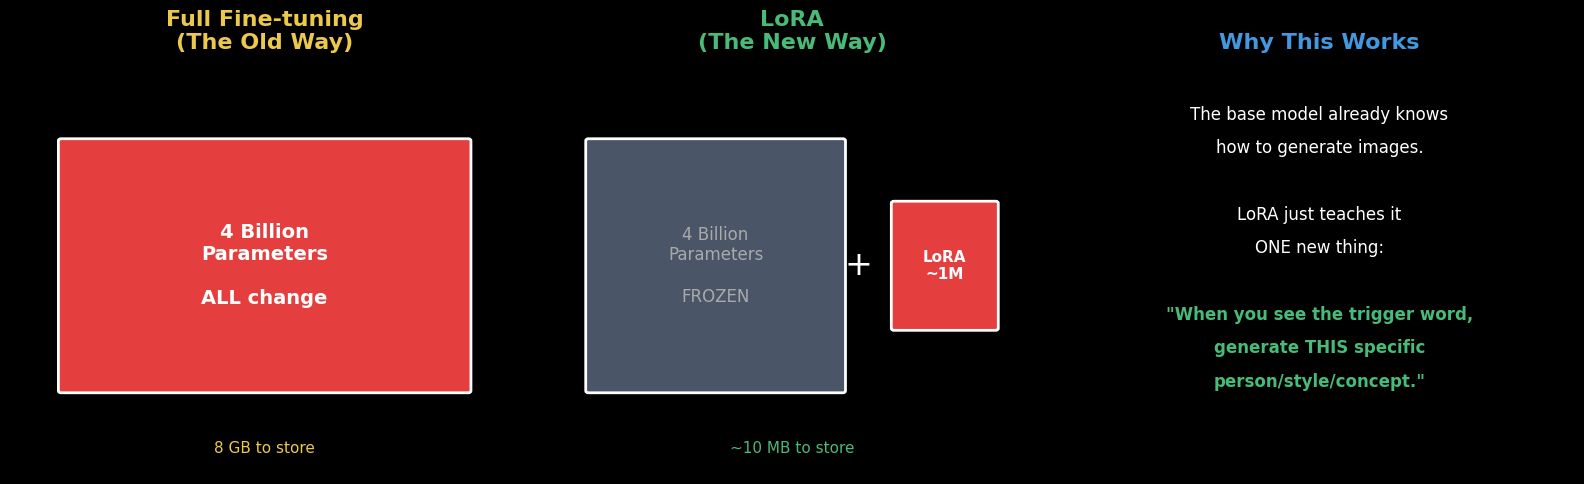


KEY TAKEAWAY
LoRA = small adapter that teaches the model one new concept
The base model stays frozen (unchanged)
You only save/share the tiny LoRA file (~10 MB vs 8 GB)


In [2]:
def explain_lora_visually():
    """
    The simplest possible explanation of what LoRA does.
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # === Panel 1: Full Fine-tuning (the old way) ===
    ax1 = axes[0]
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)
    ax1.axis('off')
    ax1.set_title('Full Fine-tuning\n(The Old Way)', color=WARNING)
    
    # Big matrix representing all weights
    rect = mpatches.FancyBboxPatch((1, 2), 8, 6,
                                    boxstyle="round,pad=0.05",
                                    facecolor=TRAINABLE, edgecolor='white', linewidth=2)
    ax1.add_patch(rect)
    ax1.text(5, 5, '4 Billion\nParameters\n\nALL change', 
             ha='center', va='center', fontsize=14, color='white', fontweight='bold')
    ax1.text(5, 0.5, '8 GB to store', ha='center', fontsize=11, color=WARNING)
    
    # === Panel 2: LoRA (the new way) ===
    ax2 = axes[1]
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
    ax2.axis('off')
    ax2.set_title('LoRA\n(The New Way)', color=GOOD)
    
    # Frozen base (big, gray)
    rect_frozen = mpatches.FancyBboxPatch((1, 2), 5, 6,
                                           boxstyle="round,pad=0.05",
                                           facecolor=FROZEN, edgecolor='white', linewidth=2)
    ax2.add_patch(rect_frozen)
    ax2.text(3.5, 5, '4 Billion\nParameters\n\nFROZEN', 
             ha='center', va='center', fontsize=12, color='#aaa')
    
    # LoRA adapter (small, red)
    rect_lora = mpatches.FancyBboxPatch((7, 3.5), 2, 3,
                                         boxstyle="round,pad=0.05",
                                         facecolor=TRAINABLE, edgecolor='white', linewidth=2)
    ax2.add_patch(rect_lora)
    ax2.text(8, 5, 'LoRA\n~1M', 
             ha='center', va='center', fontsize=11, color='white', fontweight='bold')
    
    # Plus sign
    ax2.text(6.3, 5, '+', ha='center', va='center', fontsize=24, color='white')
    
    ax2.text(5, 0.5, '~10 MB to store', ha='center', fontsize=11, color=GOOD)
    
    # === Panel 3: The Key Insight ===
    ax3 = axes[2]
    ax3.set_xlim(0, 10)
    ax3.set_ylim(0, 10)
    ax3.axis('off')
    ax3.set_title('Why This Works', color=INFO)
    
    # Text explanation
    explanation = [
        "The base model already knows",
        "how to generate images.",
        "",
        "LoRA just teaches it",
        "ONE new thing:",
        "",
        '\"When you see the trigger word,',
        'generate THIS specific',
        'person/style/concept.\"',
    ]
    
    for i, line in enumerate(explanation):
        color = 'white' if i < 5 else GOOD
        weight = 'normal' if i < 5 else 'bold'
        ax3.text(5, 8.5 - i * 0.8, line, ha='center', fontsize=12, 
                color=color, fontweight=weight)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("KEY TAKEAWAY")
    print("="*60)
    print("LoRA = small adapter that teaches the model one new concept")
    print("The base model stays frozen (unchanged)")
    print("You only save/share the tiny LoRA file (~10 MB vs 8 GB)")

explain_lora_visually()

## How Does the Math Work?

You don't need to understand the math to use LoRA effectively, but here's the intuition:

Instead of updating a huge weight matrix directly, we add two small matrices that **multiply together**:

```
New output = Original output + (small matrix B × small matrix A) × input
```

The magic: B starts as all zeros, so **at the beginning, the LoRA does nothing**. 
During training, B and A learn to make small adjustments.

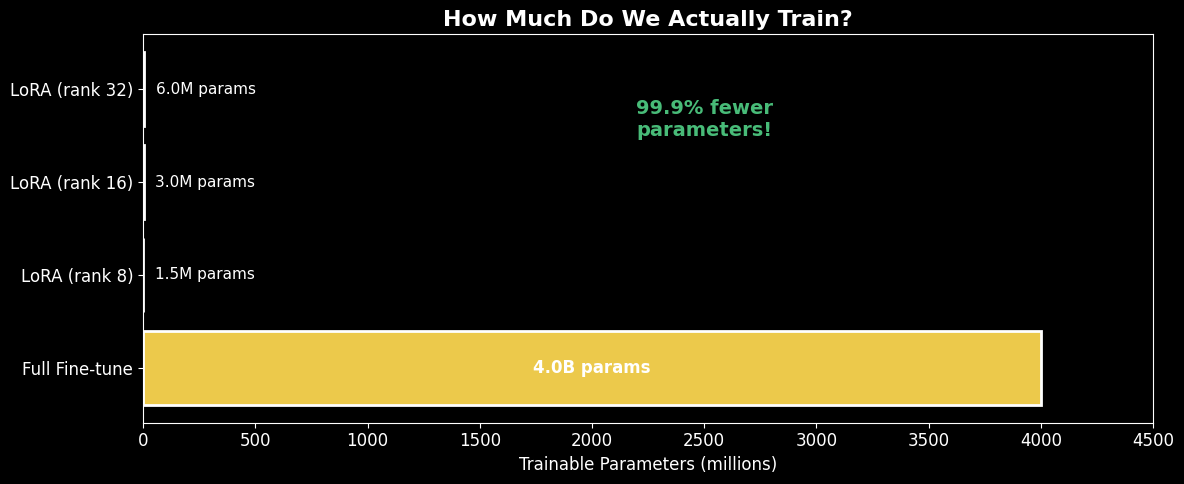


WHAT THIS MEANS
• Faster training (less to update)
• Less GPU memory needed
• Easy to share and swap LoRAs
• Can combine multiple LoRAs!


In [3]:
def show_lora_size_comparison():
    """
    Visual comparison of parameter counts.
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Data
    methods = ['Full Fine-tune', 'LoRA (rank 8)', 'LoRA (rank 16)', 'LoRA (rank 32)']
    params_millions = [4000, 1.5, 3.0, 6.0]  # In millions
    colors = [WARNING, GOOD, GOOD, GOOD]
    
    # Create bars
    bars = ax.barh(methods, params_millions, color=colors, edgecolor='white', linewidth=2)
    
    # Add labels
    for bar, param in zip(bars, params_millions):
        width = bar.get_width()
        if param > 100:
            ax.text(width/2, bar.get_y() + bar.get_height()/2, 
                   f'{param/1000:.1f}B params', 
                   ha='center', va='center', fontsize=12, fontweight='bold')
        else:
            ax.text(width + 50, bar.get_y() + bar.get_height()/2, 
                   f'{param:.1f}M params', 
                   ha='left', va='center', fontsize=11)
    
    ax.set_xlabel('Trainable Parameters (millions)', fontsize=12)
    ax.set_title('How Much Do We Actually Train?', fontsize=16)
    ax.set_xlim(0, 4500)
    
    # Add annotation
    ax.text(2500, 2.5, '99.9% fewer\nparameters!', fontsize=14, 
           color=GOOD, fontweight='bold', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("WHAT THIS MEANS")
    print("="*60)
    print("• Faster training (less to update)")
    print("• Less GPU memory needed")
    print("• Easy to share and swap LoRAs")
    print("• Can combine multiple LoRAs!")

show_lora_size_comparison()

---
# Part 2: Where Does LoRA Go?

## Klein Base 4B Architecture (Simplified)

Think of the model as a pipeline:

1. **Text comes in** → gets converted to numbers the model understands
2. **Noise comes in** → random starting point
3. **Many transformer blocks** → gradually remove noise while following the text
4. **Image comes out** → the final result

LoRA adapters go inside those transformer blocks.

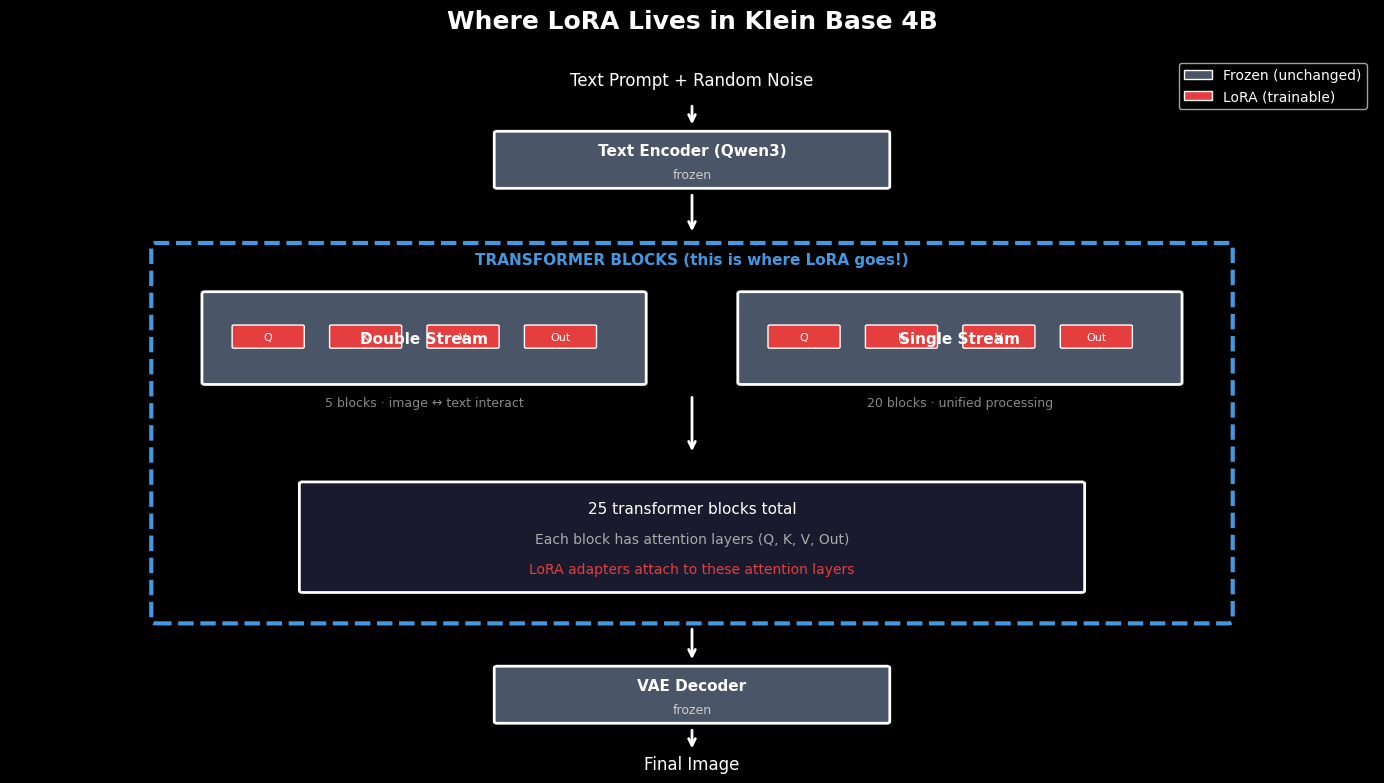


KEY TAKEAWAY
LoRA attaches to the ATTENTION layers inside transformer blocks
These control HOW the model pays attention to different parts
Everything else (text encoder, VAE) stays frozen


In [4]:
def show_architecture_simple():
    """
    Simplified view of where LoRA goes.
    """
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 12)
    ax.axis('off')
    ax.set_title('Where LoRA Lives in Klein Base 4B', fontsize=18, pad=20)
    
    # Helper function
    def draw_box(x, y, w, h, label, color, sublabel=None):
        rect = mpatches.FancyBboxPatch((x, y), w, h,
                                        boxstyle="round,pad=0.03",
                                        facecolor=color, edgecolor='white', linewidth=2)
        ax.add_patch(rect)
        ax.text(x + w/2, y + h/2 + (0.15 if sublabel else 0), label, 
               ha='center', va='center', fontsize=11, color='white', fontweight='bold')
        if sublabel:
            ax.text(x + w/2, y + h/2 - 0.25, sublabel, 
                   ha='center', va='center', fontsize=9, color='#ccc')
    
    # Input
    ax.text(7, 11.5, 'Text Prompt + Random Noise', ha='center', fontsize=12, color='white')
    ax.annotate('', xy=(7, 10.8), xytext=(7, 11.2),
               arrowprops=dict(arrowstyle='->', color='white', lw=2))
    
    # Text encoder
    draw_box(5, 9.8, 4, 0.9, 'Text Encoder (Qwen3)', FROZEN, 'frozen')
    ax.annotate('', xy=(7, 9), xytext=(7, 9.7),
               arrowprops=dict(arrowstyle='->', color='white', lw=2))
    
    # Transformer blocks section
    ax.add_patch(mpatches.FancyBboxPatch((1.5, 2.5), 11, 6.3,
                                          boxstyle="round,pad=0.05",
                                          facecolor='none', edgecolor=INFO, 
                                          linewidth=3, linestyle='--'))
    ax.text(7, 8.5, 'TRANSFORMER BLOCKS (this is where LoRA goes!)', 
           ha='center', fontsize=11, color=INFO, fontweight='bold')
    
    # Double stream blocks
    draw_box(2, 6.5, 4.5, 1.5, 'Double Stream', FROZEN)
    ax.text(4.25, 6.1, '5 blocks · image ↔ text interact', ha='center', fontsize=9, color='#888')
    
    # LoRA indicators for double stream
    for i, label in enumerate(['Q', 'K', 'V', 'Out']):
        x = 2.3 + i * 1.0
        rect = mpatches.FancyBboxPatch((x, 7.1), 0.7, 0.35,
                                        boxstyle="round,pad=0.02",
                                        facecolor=TRAINABLE, edgecolor='white', linewidth=1)
        ax.add_patch(rect)
        ax.text(x + 0.35, 7.27, label, ha='center', va='center', fontsize=8, color='white')
    
    # Arrow between blocks
    ax.annotate('', xy=(7, 5.3), xytext=(7, 6.3),
               arrowprops=dict(arrowstyle='->', color='white', lw=2))
    
    # Single stream blocks
    draw_box(7.5, 6.5, 4.5, 1.5, 'Single Stream', FROZEN)
    ax.text(9.75, 6.1, '20 blocks · unified processing', ha='center', fontsize=9, color='#888')
    
    # LoRA indicators for single stream
    for i, label in enumerate(['Q', 'K', 'V', 'Out']):
        x = 7.8 + i * 1.0
        rect = mpatches.FancyBboxPatch((x, 7.1), 0.7, 0.35,
                                        boxstyle="round,pad=0.02",
                                        facecolor=TRAINABLE, edgecolor='white', linewidth=1)
        ax.add_patch(rect)
        ax.text(x + 0.35, 7.27, label, ha='center', va='center', fontsize=8, color='white')
    
    # Summary box
    draw_box(3, 3, 8, 1.8, '', '#1a1a2e')
    ax.text(7, 4.3, '25 transformer blocks total', ha='center', fontsize=11, color='white')
    ax.text(7, 3.8, 'Each block has attention layers (Q, K, V, Out)', ha='center', fontsize=10, color='#aaa')
    ax.text(7, 3.3, 'LoRA adapters attach to these attention layers', ha='center', fontsize=10, color=TRAINABLE)
    
    # Output
    ax.annotate('', xy=(7, 1.8), xytext=(7, 2.4),
               arrowprops=dict(arrowstyle='->', color='white', lw=2))
    draw_box(5, 0.8, 4, 0.9, 'VAE Decoder', FROZEN, 'frozen')
    ax.annotate('', xy=(7, 0.3), xytext=(7, 0.7),
               arrowprops=dict(arrowstyle='->', color='white', lw=2))
    ax.text(7, 0, 'Final Image', ha='center', fontsize=12, color='white')
    
    # Legend
    legend_elements = [
        mpatches.Patch(facecolor=FROZEN, edgecolor='white', label='Frozen (unchanged)'),
        mpatches.Patch(facecolor=TRAINABLE, edgecolor='white', label='LoRA (trainable)'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("KEY TAKEAWAY")
    print("="*60)
    print("LoRA attaches to the ATTENTION layers inside transformer blocks")
    print("These control HOW the model pays attention to different parts")
    print("Everything else (text encoder, VAE) stays frozen")

show_architecture_simple()

## What Do the Attention Layers Control?

This is the intuition that helps you understand what LoRA is learning:

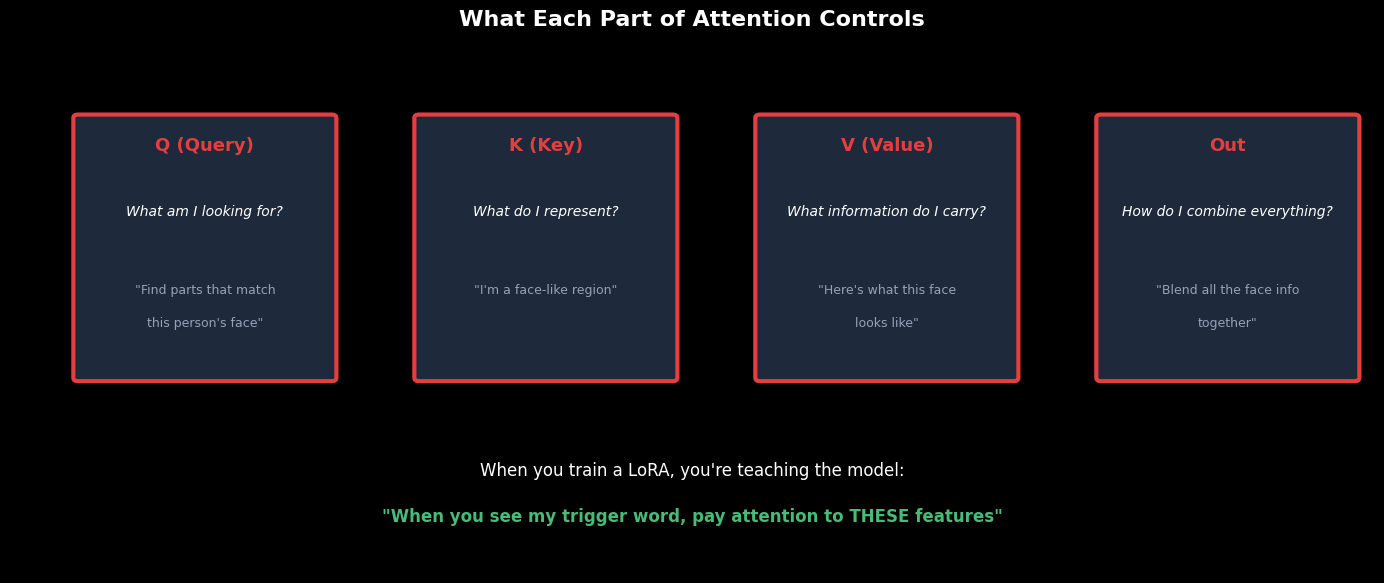

In [5]:
def explain_attention_layers():
    """
    What each attention component does, in plain English.
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 8)
    ax.axis('off')
    ax.set_title('What Each Part of Attention Controls', fontsize=16, pad=20)
    
    components = [
        ('Q (Query)', 'What am I looking for?', 
         '"Find parts that match this person\'s face"', 2, TRAINABLE),
        ('K (Key)', 'What do I represent?',
         '"I\'m a face-like region"', 5.5, TRAINABLE),
        ('V (Value)', 'What information do I carry?',
         '"Here\'s what this face looks like"', 9, TRAINABLE),
        ('Out', 'How do I combine everything?',
         '"Blend all the face info together"', 12.5, TRAINABLE),
    ]
    
    for name, question, example, x, color in components:
        # Box
        rect = mpatches.FancyBboxPatch((x-1.3, 3), 2.6, 4,
                                        boxstyle="round,pad=0.05",
                                        facecolor='#1e293b', edgecolor=color, linewidth=3)
        ax.add_patch(rect)
        
        # Name
        ax.text(x, 6.5, name, ha='center', fontsize=13, fontweight='bold', color=color)
        
        # Question
        ax.text(x, 5.5, question, ha='center', fontsize=10, color='white', style='italic')
        
        # Example (wrapped)
        words = example.split()
        lines = []
        current = []
        for w in words:
            current.append(w)
            if len(' '.join(current)) > 20:
                lines.append(' '.join(current))
                current = []
        if current:
            lines.append(' '.join(current))
        
        for i, line in enumerate(lines):
            ax.text(x, 4.3 - i*0.5, line, ha='center', fontsize=9, color='#94a3b8')
    
    # Bottom summary
    ax.text(7, 1.5, 'When you train a LoRA, you\'re teaching the model:', 
           ha='center', fontsize=12, color='white')
    ax.text(7, 0.8, '"When you see my trigger word, pay attention to THESE features"', 
           ha='center', fontsize=12, color=GOOD, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

explain_attention_layers()

---
# Part 3: Hyperparameters — The Knobs You Can Turn

There are really only **4 things** you need to decide:

1. **Rank** — How much can the LoRA learn?
2. **Learning Rate** — How fast does it learn?
3. **Training Steps** — How long does it train?
4. **Alpha** — How strong is the effect?

Let's build intuition for each one.

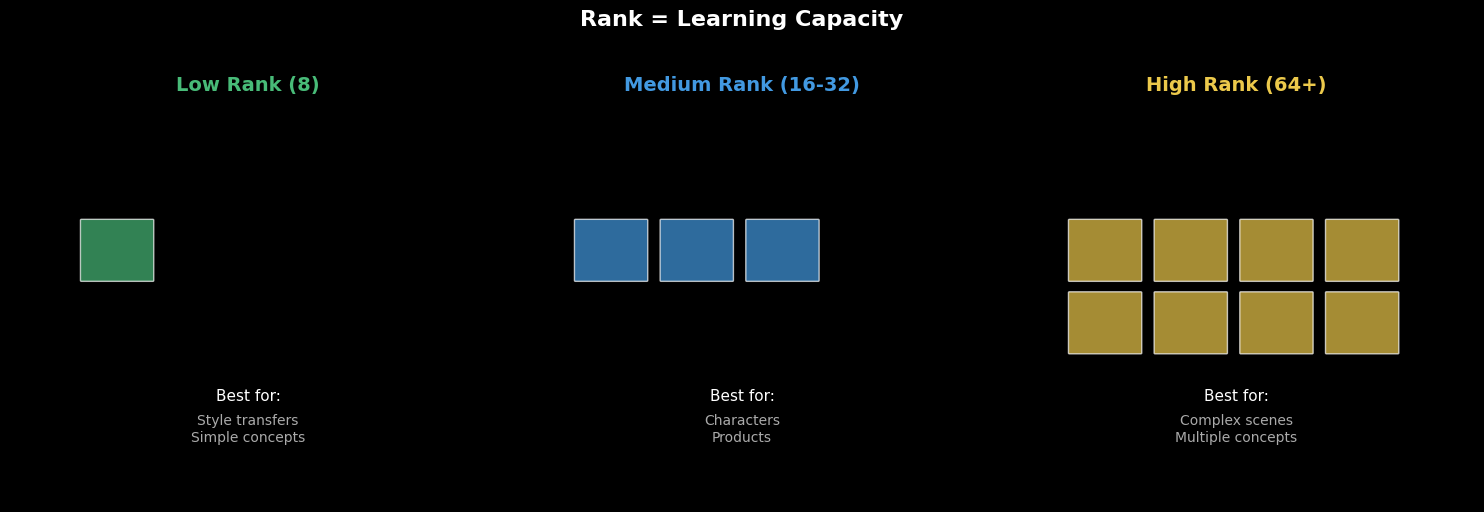


RANK INTUITION
Higher rank = more capacity to learn complex things
BUT also = more risk of overfitting (memorizing, not learning)

Start with rank 16. Only go higher if results are too weak.


In [6]:
def explain_rank():
    """
    Visual explanation of what rank means.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    configs = [
        ('Low Rank (8)', 8, 'Style transfers\nSimple concepts', GOOD),
        ('Medium Rank (16-32)', 24, 'Characters\nProducts', INFO),
        ('High Rank (64+)', 64, 'Complex scenes\nMultiple concepts', WARNING),
    ]
    
    for ax, (title, rank, use_case, color) in zip(axes, configs):
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.axis('off')
        ax.set_title(title, fontsize=14, color=color)
        
        # Draw capacity visualization (more squares = more capacity)
        n_squares = rank // 8
        for i in range(n_squares):
            row = i // 4
            col = i % 4
            rect = mpatches.FancyBboxPatch((1.5 + col * 1.8, 5.5 - row * 1.8), 1.5, 1.5,
                                            boxstyle="round,pad=0.02",
                                            facecolor=color, edgecolor='white', linewidth=1,
                                            alpha=0.7)
            ax.add_patch(rect)
        
        # Use case
        ax.text(5, 2.5, 'Best for:', ha='center', fontsize=11, color='white')
        ax.text(5, 1.5, use_case, ha='center', fontsize=10, color='#aaa')
    
    plt.suptitle('Rank = Learning Capacity', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("RANK INTUITION")
    print("="*60)
    print("Higher rank = more capacity to learn complex things")
    print("BUT also = more risk of overfitting (memorizing, not learning)")
    print("")
    print("Start with rank 16. Only go higher if results are too weak.")

explain_rank()

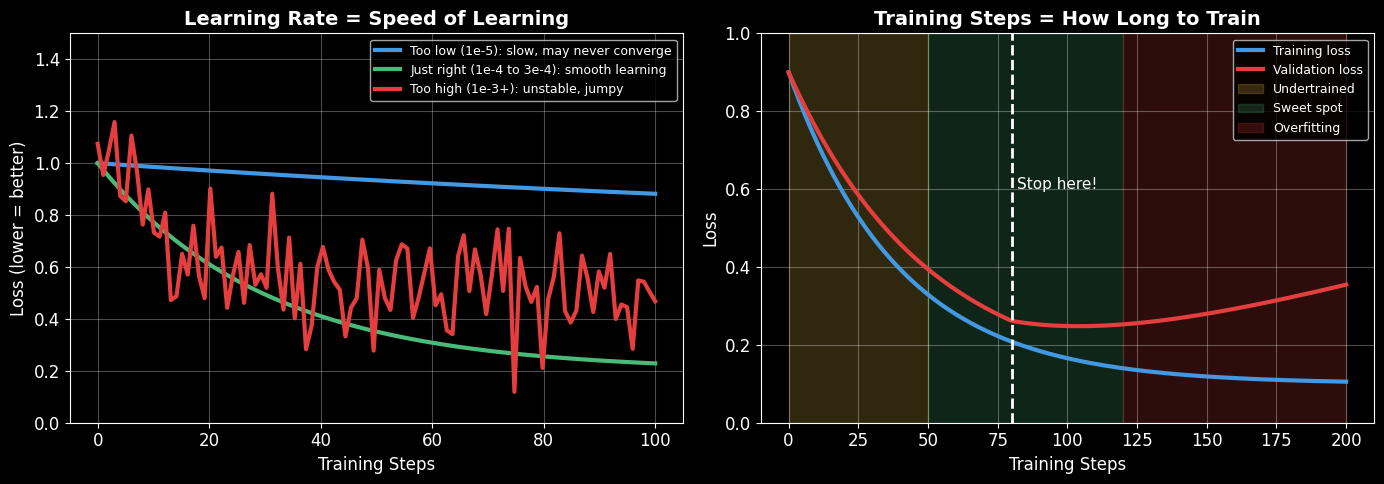


PRACTICAL ADVICE
Learning rate: Start with 1e-4 or 3e-4
Steps: 500-1500 depending on dataset size

Watch the loss curves! Stop when validation starts rising.


In [7]:
def explain_learning_rate_and_steps():
    """
    Visual explanation of learning rate and steps.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # === Learning Rate ===
    ax1 = axes[0]
    ax1.set_title('Learning Rate = Speed of Learning', fontsize=14)
    
    steps = np.linspace(0, 100, 100)
    
    # Too low
    too_low = 1 - 0.3 * (1 - np.exp(-steps / 200))
    ax1.plot(steps, too_low, '-', color=INFO, linewidth=3, label='Too low (1e-5): slow, may never converge')
    
    # Just right
    just_right = 1 - 0.8 * (1 - np.exp(-steps / 30))
    ax1.plot(steps, just_right, '-', color=GOOD, linewidth=3, label='Just right (1e-4 to 3e-4): smooth learning')
    
    # Too high
    np.random.seed(42)
    too_high = 1 - 0.5 * (1 - np.exp(-steps / 20)) + np.random.randn(100) * 0.15
    ax1.plot(steps, too_high, '-', color=TRAINABLE, linewidth=3, label='Too high (1e-3+): unstable, jumpy')
    
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Loss (lower = better)')
    ax1.legend(loc='upper right', fontsize=9)
    ax1.set_ylim(0, 1.5)
    ax1.grid(True, alpha=0.3)
    
    # === Training Steps ===
    ax2 = axes[1]
    ax2.set_title('Training Steps = How Long to Train', fontsize=14)
    
    steps_full = np.linspace(0, 200, 200)
    train_loss = 0.8 * np.exp(-steps_full / 40) + 0.1
    val_loss = 0.8 * np.exp(-steps_full / 50) + 0.1 + 0.002 * np.maximum(0, steps_full - 80)
    
    ax2.plot(steps_full, train_loss, '-', color=INFO, linewidth=3, label='Training loss')
    ax2.plot(steps_full, val_loss, '-', color=TRAINABLE, linewidth=3, label='Validation loss')
    
    # Mark regions
    ax2.axvspan(0, 50, alpha=0.2, color=WARNING, label='Undertrained')
    ax2.axvspan(50, 120, alpha=0.2, color=GOOD, label='Sweet spot')
    ax2.axvspan(120, 200, alpha=0.2, color=TRAINABLE, label='Overfitting')
    
    ax2.axvline(x=80, color='white', linestyle='--', linewidth=2)
    ax2.text(82, 0.6, 'Stop here!', fontsize=11, color='white')
    
    ax2.set_xlabel('Training Steps')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right', fontsize=9)
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("PRACTICAL ADVICE")
    print("="*60)
    print("Learning rate: Start with 1e-4 or 3e-4")
    print("Steps: 500-1500 depending on dataset size")
    print("")
    print("Watch the loss curves! Stop when validation starts rising.")

explain_learning_rate_and_steps()

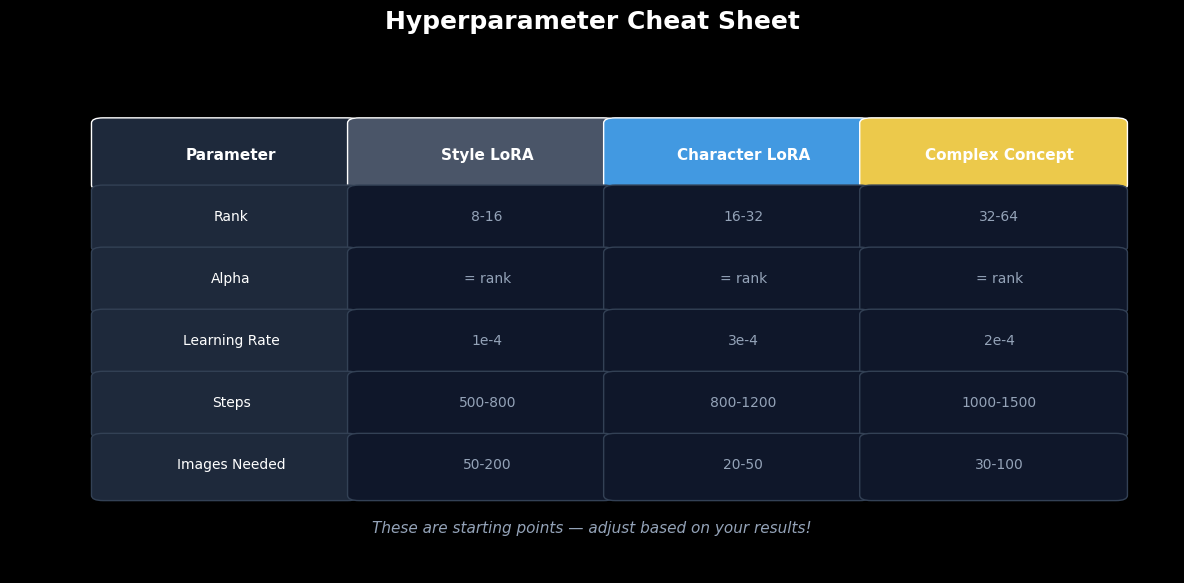

In [8]:
def show_hyperparameter_cheatsheet():
    """
    Simple reference table.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('off')
    ax.set_title('Hyperparameter Cheat Sheet', fontsize=18, fontweight='bold', pad=20)
    
    # Table data
    headers = ['Parameter', 'Style LoRA', 'Character LoRA', 'Complex Concept']
    rows = [
        ['Rank', '8-16', '16-32', '32-64'],
        ['Alpha', '= rank', '= rank', '= rank'],
        ['Learning Rate', '1e-4', '3e-4', '2e-4'],
        ['Steps', '500-800', '800-1200', '1000-1500'],
        ['Images Needed', '50-200', '20-50', '30-100'],
    ]
    
    # Draw table
    cell_height = 0.12
    cell_width = 0.22
    start_y = 0.75
    start_x = 0.08
    
    # Headers
    for i, header in enumerate(headers):
        x = start_x + i * cell_width
        color = '#1e293b' if i == 0 else ['#4a5568', INFO, WARNING][i-1]
        rect = mpatches.FancyBboxPatch((x, start_y), cell_width - 0.01, cell_height,
                                        boxstyle="round,pad=0.01",
                                        facecolor=color, edgecolor='white', linewidth=1)
        ax.add_patch(rect)
        ax.text(x + cell_width/2, start_y + cell_height/2, header,
               ha='center', va='center', fontsize=11, fontweight='bold', color='white')
    
    # Rows
    for row_idx, row in enumerate(rows):
        y = start_y - (row_idx + 1) * cell_height
        for col_idx, cell in enumerate(row):
            x = start_x + col_idx * cell_width
            color = '#1e293b' if col_idx == 0 else '#0f172a'
            rect = mpatches.FancyBboxPatch((x, y), cell_width - 0.01, cell_height - 0.01,
                                            boxstyle="round,pad=0.01",
                                            facecolor=color, edgecolor='#334155', linewidth=1)
            ax.add_patch(rect)
            ax.text(x + cell_width/2, y + cell_height/2, cell,
                   ha='center', va='center', fontsize=10, 
                   color='white' if col_idx == 0 else '#94a3b8')
    
    # Footer note
    ax.text(0.5, 0.08, 'These are starting points — adjust based on your results!', 
           ha='center', fontsize=11, color='#94a3b8', style='italic',
           transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()

show_hyperparameter_cheatsheet()

---
# Part 4: Data — The Most Important Part

**Reality check:** Your LoRA can only be as good as your training data.

The model will learn:
- Whatever is consistent across your images → **intended concept**
- Whatever is accidentally consistent → **unwanted artifacts**

This is why data curation matters more than hyperparameter tuning.

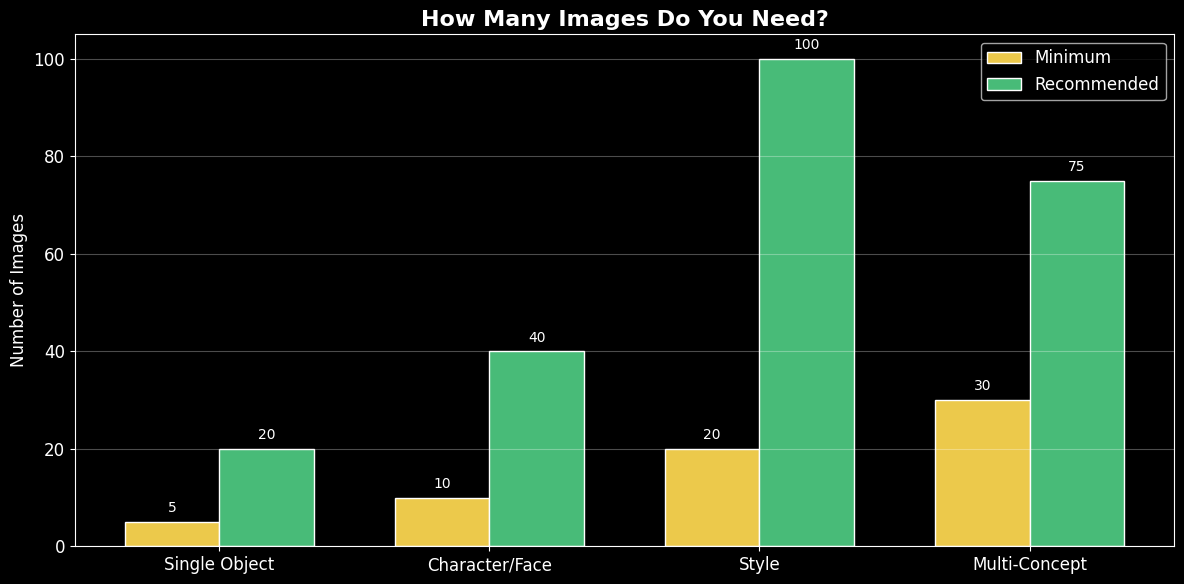


THE GOLDEN RULE
20 excellent images > 200 mediocre images

Quality checklist:
  ✓ High resolution (1024px+)
  ✓ Sharp, well-lit
  ✓ No watermarks
  ✓ Diverse poses/angles/backgrounds
  ✓ No near-duplicates


In [9]:
def show_data_quantity_guide():
    """
    How many images do you need?
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    categories = ['Single Object', 'Character/Face', 'Style', 'Multi-Concept']
    min_images = [5, 10, 20, 30]
    recommended = [20, 40, 100, 75]
    
    x = np.arange(len(categories))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, min_images, width, label='Minimum', color=WARNING, edgecolor='white')
    bars2 = ax.bar(x + width/2, recommended, width, label='Recommended', color=GOOD, edgecolor='white')
    
    ax.set_ylabel('Number of Images')
    ax.set_title('How Many Images Do You Need?', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 2,
                   f'{int(height)}', ha='center', fontsize=10, color='white')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("THE GOLDEN RULE")
    print("="*60)
    print("20 excellent images > 200 mediocre images")
    print("")
    print("Quality checklist:")
    print("  ✓ High resolution (1024px+)")
    print("  ✓ Sharp, well-lit")
    print("  ✓ No watermarks")
    print("  ✓ Diverse poses/angles/backgrounds")
    print("  ✓ No near-duplicates")

show_data_quantity_guide()

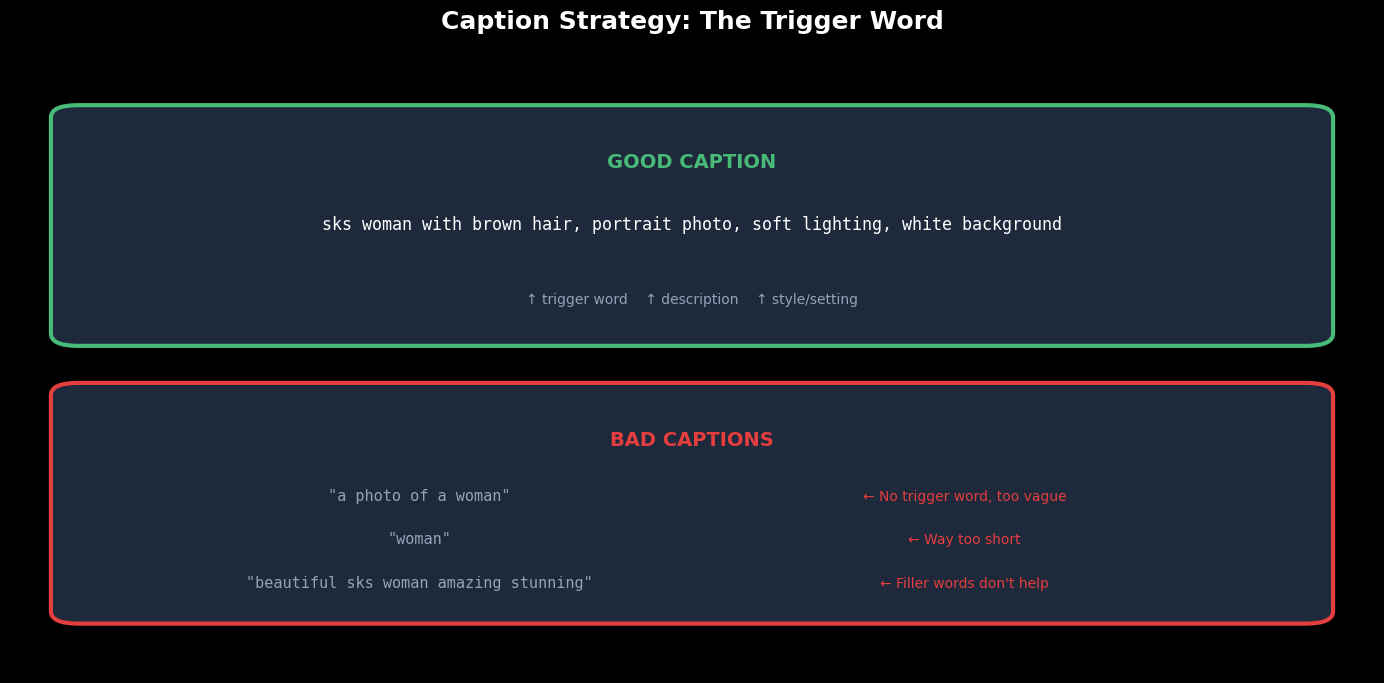


TRIGGER WORD TIPS
• Use a rare/unique token: sks, ohwx, xyz123
• Put it at the START of every caption
• Be consistent — same trigger in ALL captions
• Vary the rest of the caption (don't copy-paste)


In [10]:
def explain_captions():
    """
    Caption strategy explained simply.
    """
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.axis('off')
    ax.set_title('Caption Strategy: The Trigger Word', fontsize=18, fontweight='bold', pad=20)
    
    # Good example
    ax.add_patch(mpatches.FancyBboxPatch((0.05, 0.55), 0.9, 0.35,
                                          boxstyle="round,pad=0.02",
                                          facecolor='#1e293b', edgecolor=GOOD, linewidth=3,
                                          transform=ax.transAxes))
    ax.text(0.5, 0.82, 'GOOD CAPTION', ha='center', fontsize=14, fontweight='bold', 
           color=GOOD, transform=ax.transAxes)
    ax.text(0.5, 0.72, 'sks woman with brown hair, portrait photo, soft lighting, white background', 
           ha='center', fontsize=12, color='white', transform=ax.transAxes,
           family='monospace')
    ax.text(0.5, 0.60, '↑ trigger word    ↑ description    ↑ style/setting', 
           ha='center', fontsize=10, color='#94a3b8', transform=ax.transAxes)
    
    # Bad examples
    ax.add_patch(mpatches.FancyBboxPatch((0.05, 0.1), 0.9, 0.35,
                                          boxstyle="round,pad=0.02",
                                          facecolor='#1e293b', edgecolor=TRAINABLE, linewidth=3,
                                          transform=ax.transAxes))
    ax.text(0.5, 0.37, 'BAD CAPTIONS', ha='center', fontsize=14, fontweight='bold', 
           color=TRAINABLE, transform=ax.transAxes)
    
    bad_examples = [
        ('"a photo of a woman"', 'No trigger word, too vague'),
        ('"woman"', 'Way too short'),
        ('"beautiful sks woman amazing stunning"', 'Filler words don\'t help'),
    ]
    
    for i, (bad, reason) in enumerate(bad_examples):
        y = 0.28 - i * 0.07
        ax.text(0.3, y, bad, ha='center', fontsize=11, color='#94a3b8', 
               transform=ax.transAxes, family='monospace')
        ax.text(0.7, y, f'← {reason}', ha='center', fontsize=10, color=TRAINABLE, 
               transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("TRIGGER WORD TIPS")
    print("="*60)
    print("• Use a rare/unique token: sks, ohwx, xyz123")
    print("• Put it at the START of every caption")
    print("• Be consistent — same trigger in ALL captions")
    print("• Vary the rest of the caption (don't copy-paste)")

explain_captions()

---
# Part 5: When Things Go Wrong

These are the most common problems and how to fix them.

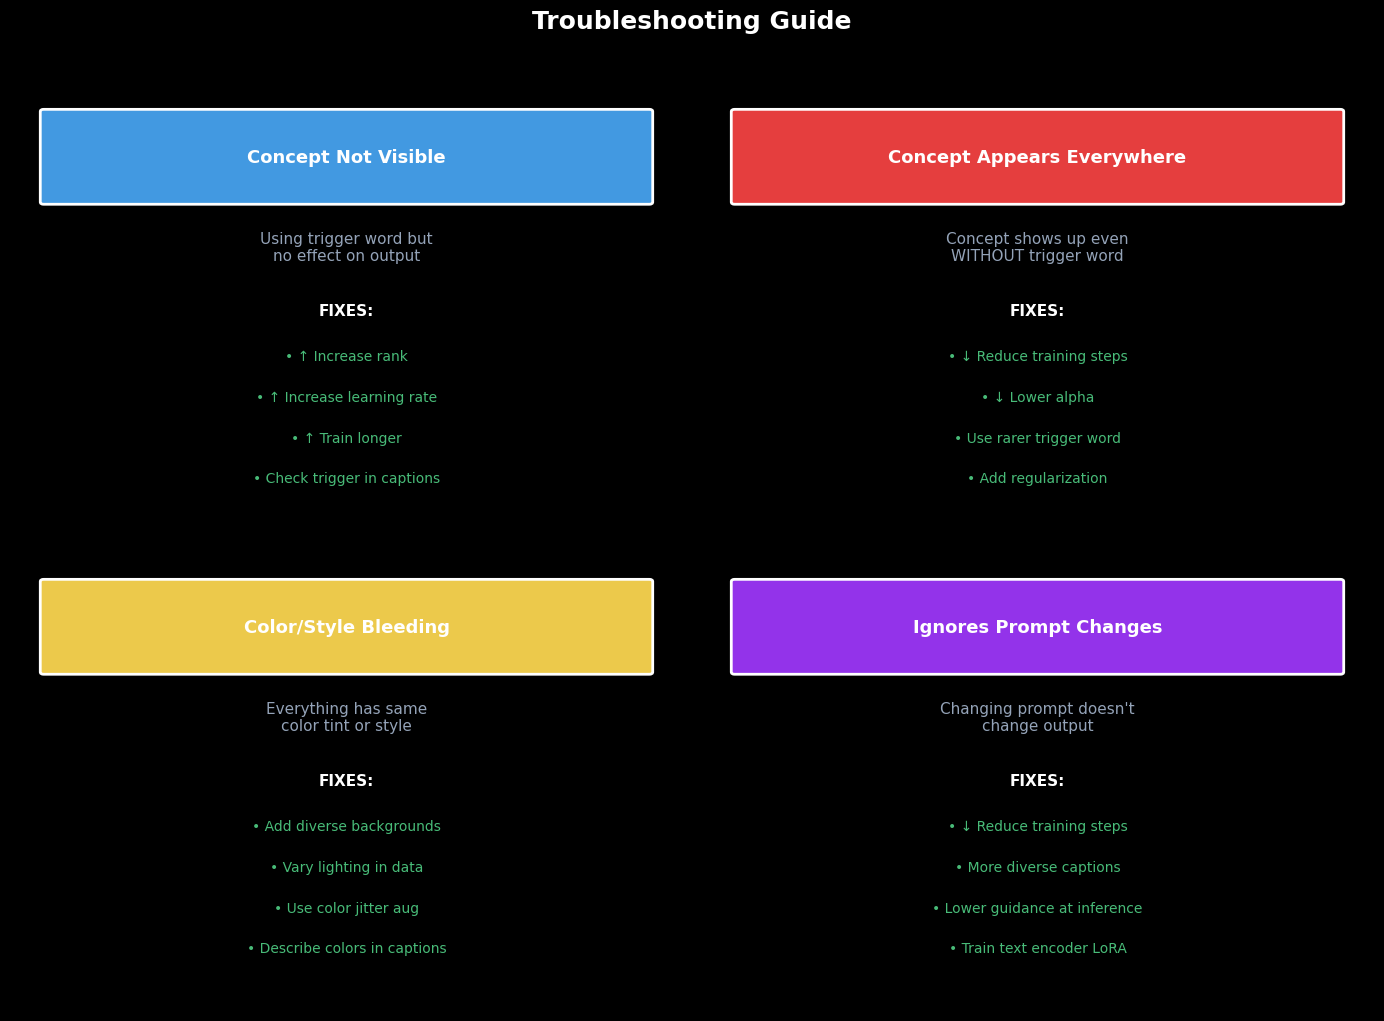

In [11]:
def show_failure_modes():
    """
    Common problems and fixes.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    problems = [
        ('Concept Not Visible', 
         'Using trigger word but\nno effect on output',
         ['↑ Increase rank', '↑ Increase learning rate', '↑ Train longer', 'Check trigger in captions'],
         INFO),
        ('Concept Appears Everywhere',
         'Concept shows up even\nWITHOUT trigger word',
         ['↓ Reduce training steps', '↓ Lower alpha', 'Use rarer trigger word', 'Add regularization'],
         TRAINABLE),
        ('Color/Style Bleeding',
         'Everything has same\ncolor tint or style',
         ['Add diverse backgrounds', 'Vary lighting in data', 'Use color jitter aug', 'Describe colors in captions'],
         WARNING),
        ('Ignores Prompt Changes',
         'Changing prompt doesn\'t\nchange output',
         ['↓ Reduce training steps', 'More diverse captions', 'Lower guidance at inference', 'Train text encoder LoRA'],
         '#9333ea'),
    ]
    
    for ax, (title, symptom, fixes, color) in zip(axes.flat, problems):
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.axis('off')
        
        # Title
        ax.add_patch(mpatches.FancyBboxPatch((0.5, 7.5), 9, 2,
                                              boxstyle="round,pad=0.05",
                                              facecolor=color, edgecolor='white', linewidth=2))
        ax.text(5, 8.5, title, ha='center', va='center', fontsize=13, 
               fontweight='bold', color='white')
        
        # Symptom
        ax.text(5, 6.5, symptom, ha='center', va='center', fontsize=11, color='#94a3b8')
        
        # Fixes
        ax.text(5, 5, 'FIXES:', ha='center', fontsize=11, fontweight='bold', color='white')
        for i, fix in enumerate(fixes):
            ax.text(5, 4 - i * 0.9, f'• {fix}', ha='center', fontsize=10, color=GOOD)
    
    plt.suptitle('Troubleshooting Guide', fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

show_failure_modes()

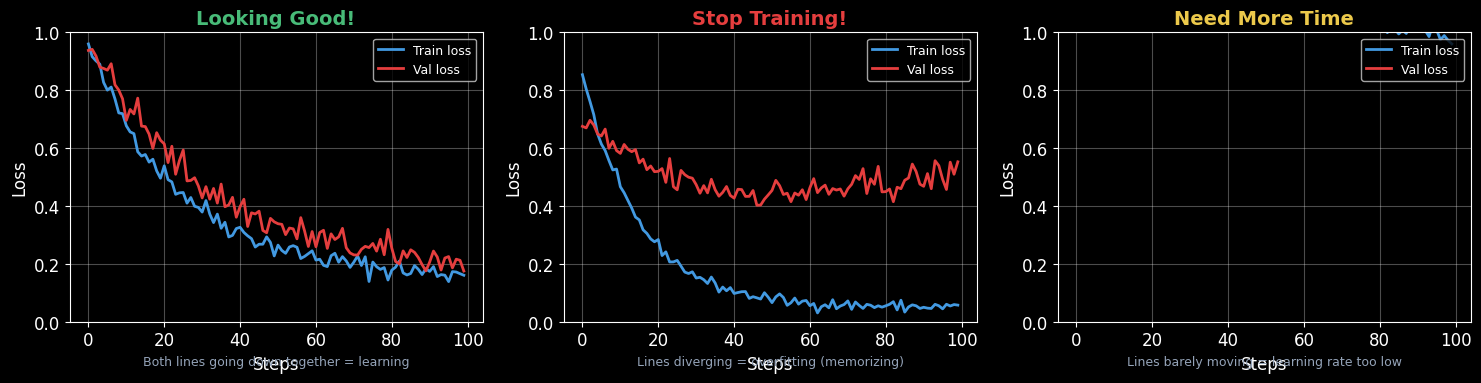


SIMPLE RULE
Train and validation should go down TOGETHER.
If validation goes UP while train goes DOWN → stop training!


In [12]:
def show_training_curves():
    """
    How to read training curves - the simple version.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    steps = np.arange(100)
    np.random.seed(42)
    
    scenarios = [
        ('Looking Good!', GOOD,
         0.8 * np.exp(-steps/25) + 0.15 + np.random.randn(100)*0.02,
         0.8 * np.exp(-steps/30) + 0.18 + np.random.randn(100)*0.03,
         'Both lines going down together = learning'),
        ('Stop Training!', TRAINABLE,
         0.8 * np.exp(-steps/15) + 0.05 + np.random.randn(100)*0.01,
         0.5 * np.exp(-steps/30) + 0.2 + 0.003*steps + np.random.randn(100)*0.03,
         'Lines diverging = overfitting (memorizing)'),
        ('Need More Time', WARNING,
         0.8 * np.exp(-steps/200) + 0.5 + np.random.randn(100)*0.02,
         0.8 * np.exp(-steps/250) + 0.55 + np.random.randn(100)*0.03,
         'Lines barely moving = learning rate too low'),
    ]
    
    for ax, (title, color, train, val, note) in zip(axes, scenarios):
        ax.plot(steps, train, '-', color=INFO, linewidth=2, label='Train loss')
        ax.plot(steps, val, '-', color=TRAINABLE, linewidth=2, label='Val loss')
        ax.set_title(title, fontsize=14, color=color, fontweight='bold')
        ax.set_xlabel('Steps')
        ax.set_ylabel('Loss')
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)
        
        # Add note at bottom
        ax.text(0.5, -0.15, note, ha='center', fontsize=9, color='#94a3b8',
               transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("SIMPLE RULE")
    print("="*60)
    print("Train and validation should go down TOGETHER.")
    print("If validation goes UP while train goes DOWN → stop training!")

show_training_curves()

---
# Quick Reference Card

Copy this for your notes:

In [13]:
def print_quick_reference():
    """Print a copy-paste quick reference."""
    
    print("""
╔══════════════════════════════════════════════════════════════╗
║           LORA FINE-TUNING QUICK REFERENCE                   ║
║                    Klein Base 4B                             ║
╠══════════════════════════════════════════════════════════════╣
║                                                              ║
║  STARTING POINT (adjust from here):                         ║
║  ─────────────────────────────────────                      ║
║  • Rank: 16                                                  ║
║  • Alpha: 16 (same as rank)                                  ║
║  • Learning rate: 3e-4                                       ║
║  • Steps: 1000                                               ║
║  • Batch size: 1-4                                           ║
║  • Guidance: 4.0                                             ║
║                                                              ║
║  DATA REQUIREMENTS:                                          ║
║  ─────────────────────────────────────                      ║
║  • Style: 50-200 images                                      ║
║  • Character: 20-50 images                                   ║
║  • Resolution: 1024px+ on shortest side                      ║
║  • Caption format: "sks [description], [style], [setting]"   ║
║                                                              ║
║  IF NOT WORKING:                                             ║
║  ─────────────────────────────────────                      ║
║  • No effect → ↑ rank, ↑ LR, ↑ steps                        ║
║  • Too strong → ↓ steps, ↓ alpha                            ║
║  • Color bleed → more diverse data                          ║
║  • Ignores prompt → ↓ steps, diverse captions               ║
║                                                              ║
╚══════════════════════════════════════════════════════════════╝
    """)

print_quick_reference()


╔══════════════════════════════════════════════════════════════╗
║           LORA FINE-TUNING QUICK REFERENCE                   ║
║                    Klein Base 4B                             ║
╠══════════════════════════════════════════════════════════════╣
║                                                              ║
║  STARTING POINT (adjust from here):                         ║
║  ─────────────────────────────────────                      ║
║  • Rank: 16                                                  ║
║  • Alpha: 16 (same as rank)                                  ║
║  • Learning rate: 3e-4                                       ║
║  • Steps: 1000                                               ║
║  • Batch size: 1-4                                           ║
║  • Guidance: 4.0                                             ║
║                                                              ║
║  DATA REQUIREMENTS:                                          ║
║  ───────────────────────

---

# Summary

**What we covered:**

1. **LoRA = small adapters** that teach the model one new thing
2. **They go in attention layers** inside the transformer blocks
3. **Key hyperparameters:** rank (capacity), LR (speed), steps (duration), alpha (strength)
4. **Data quality > quantity** — 20 great images beats 200 mediocre ones
5. **Watch your training curves** — stop when validation diverges

**The most important insight:**

> LoRA works because fine-tuning changes are naturally "low rank" — 
> you're not changing the whole model, just teaching it one specific thing.

---

*Workshop materials for Black Forest Labs*